## Predicción del tráfico

# Importe de bibliotecas

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.pyplot as plotter

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Modeling

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import (
    DecisionTreeClassifier, 
    DecisionTreeRegressor
)

from sklearn.ensemble import (
    RandomForestClassifier, 
    RandomForestRegressor
)
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import (
    SVC, 
    SVR
)

from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.metrics import classification_report, confusion_matrix#, plot_confusion_matrix

from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso
)

from sklearn.model_selection import(
    train_test_split,# used to split the data into training and testing
    cross_val_score,
    GridSearchCV
)

from alibi.explainers import AnchorTabular

D:\PROGRAMAS\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Análisis del dataset

In [3]:
df = pd.read_csv("./datos/TrafficTwoMonth.csv") # Traffic.csv
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal
...,...,...,...,...,...,...,...,...,...
5947,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
5948,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
5949,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
5950,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [4]:
df.isnull().sum()

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               5952 non-null   object
 1   Date               5952 non-null   int64 
 2   Day of the week    5952 non-null   object
 3   CarCount           5952 non-null   int64 
 4   BikeCount          5952 non-null   int64 
 5   BusCount           5952 non-null   int64 
 6   TruckCount         5952 non-null   int64 
 7   Total              5952 non-null   int64 
 8   Traffic Situation  5952 non-null   object
dtypes: int64(6), object(3)
memory usage: 418.6+ KB


None

In [6]:
df["Date"].value_counts()

10    192
26    192
8     192
7     192
6     192
5     192
4     192
3     192
2     192
1     192
31    192
30    192
29    192
28    192
27    192
25    192
11    192
24    192
23    192
22    192
21    192
20    192
19    192
18    192
17    192
16    192
15    192
14    192
13    192
12    192
9     192
Name: Date, dtype: int64

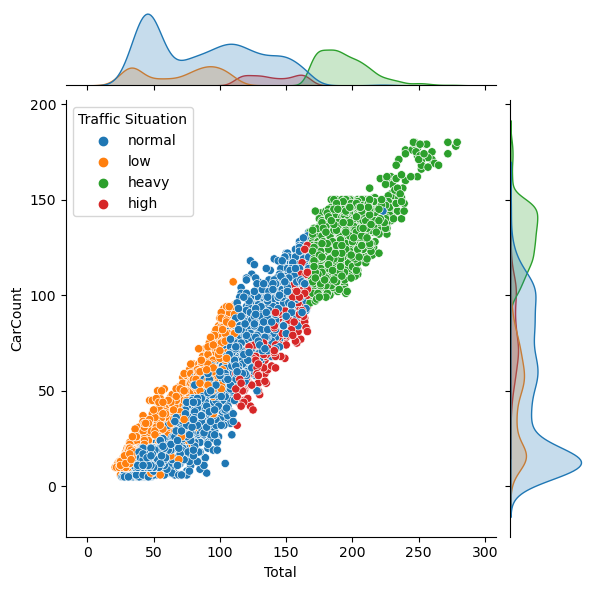

In [7]:
import seaborn as sns
sns.jointplot(data=df, x="Total", y="CarCount", hue="Traffic Situation")

<Axes: xlabel='CarCount', ylabel='Count'>

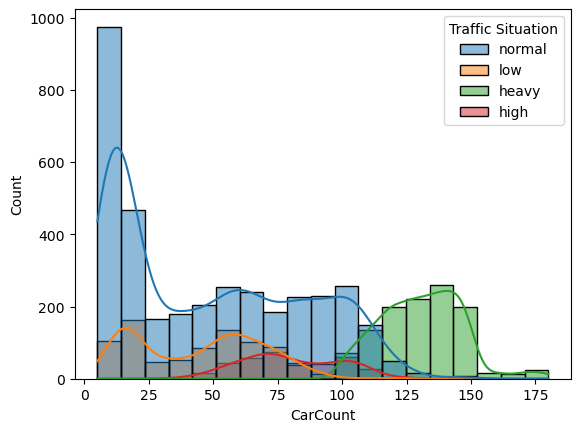

In [8]:
sns.histplot(df,x='CarCount',hue='Traffic Situation',kde=True)

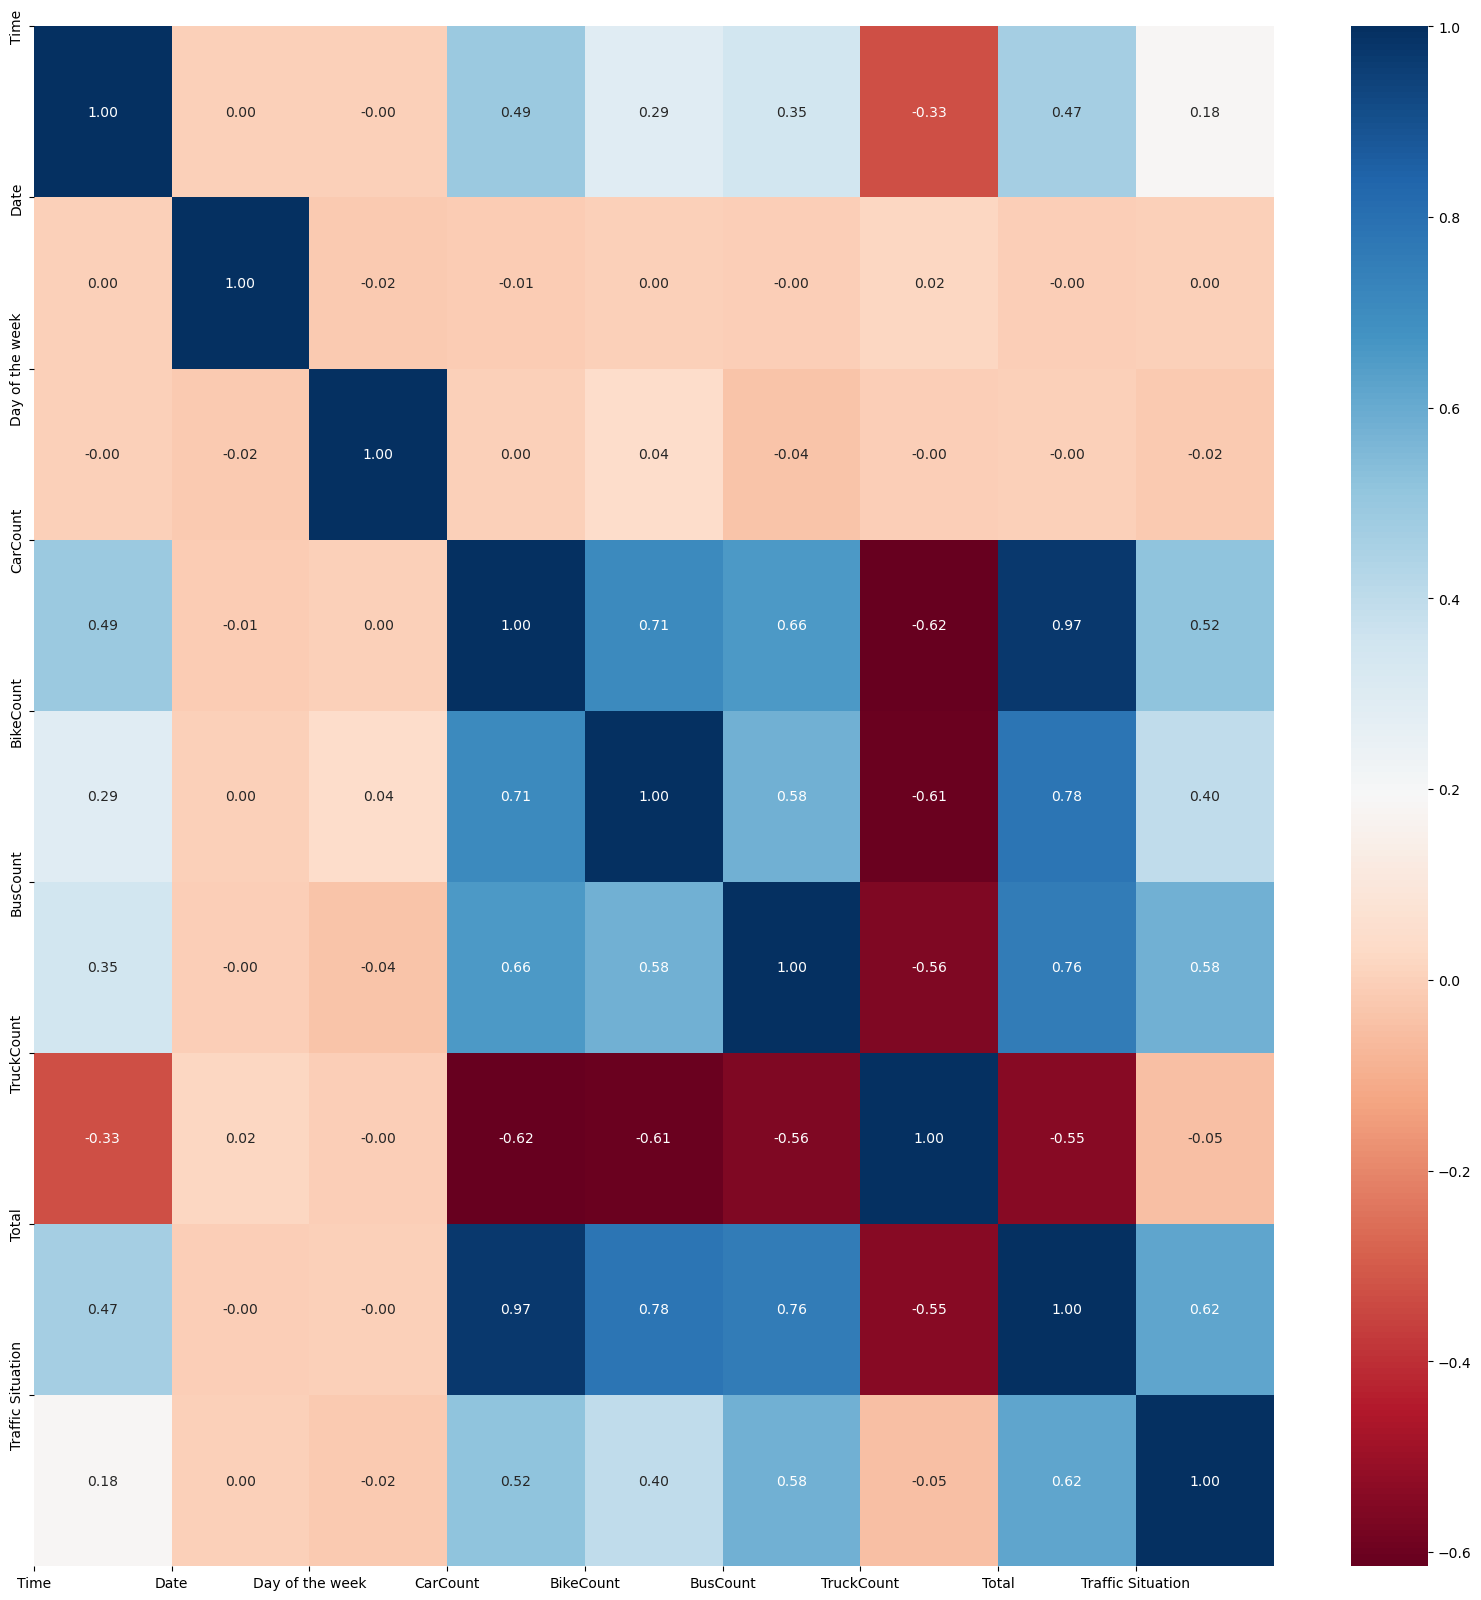

In [9]:
# esto es la preparación del dataset que se hace despues pero para que funciones el corr con todas las columnas hay que hacerlo ahora también.
temp=df
temp['Traffic Situation'] = temp['Traffic Situation'].replace({'low':0, 'normal':1, 'heavy':2, 'high':3})
temp['Day of the week'] = temp['Day of the week'].replace({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday': 6,'Sunday':7})

le = LabelEncoder()
temp['Time'] = le.fit_transform(temp['Time'])

corr = temp.corr(method='pearson')
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

# Preparación del dataset

In [10]:
df['Traffic Situation'] = df['Traffic Situation'].replace({'low':0, 'normal':1, 'heavy':2, 'high':3})

df['Day of the week'] = df['Day of the week'].replace({'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday': 6,'Sunday':7})

la columna de tiempo no se puede usar como esta, asi que voy a pasarla a formato de 24 horas y despues a minutos porque no hay segundos en ninguna

In [11]:
df['NewTime'] = (pd.to_datetime(df['Time']).dt.hour * 60) + pd.to_datetime(df['Time']).dt.minute #Minute in separate column

df['Time'] = df['NewTime']
df = df.drop(columns=['NewTime'],axis=1)
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,0,10,2,13,2,2,24,41,1
1,0,10,2,14,1,1,36,52,1
2,0,10,2,10,2,2,32,46,1
3,0,10,2,10,2,2,36,50,1
4,0,10,2,11,2,1,34,48,1
...,...,...,...,...,...,...,...,...,...
5947,0,9,4,16,3,1,36,56,1
5948,0,9,4,11,0,1,30,42,1
5949,0,9,4,15,4,1,25,45,1
5950,0,9,4,16,5,0,27,48,1


In [12]:

features = df.drop(['Traffic Situation'], axis=1)
target = df['Traffic Situation']


numeric_columns = ['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']
scaler = MinMaxScaler()
features[numeric_columns] = scaler.fit_transform(features[numeric_columns])


df_final = pd.concat([features, pd.Series(target, name='Traffic Situation')], axis=1)

df_final


,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,0.0,0.300000,0.166667,0.045714,0.028571,0.04,0.400000,0.077519,1
1,0.0,0.300000,0.166667,0.051429,0.014286,0.02,0.600000,0.120155,1
2,0.0,0.300000,0.166667,0.028571,0.028571,0.04,0.533333,0.096899,1
3,0.0,0.300000,0.166667,0.028571,0.028571,0.04,0.600000,0.112403,1
4,0.0,0.300000,0.166667,0.034286,0.028571,0.02,0.566667,0.104651,1
...,...,...,...,...,...,...,...,...,...
5947,0.0,0.266667,0.500000,0.062857,0.042857,0.02,0.600000,0.135659,1
5948,0.0,0.266667,0.500000,0.034286,0.000000,0.02,0.500000,0.081395,1
5949,0.0,0.266667,0.500000,0.057143,0.057143,0.02,0.416667,0.093023,1
5950,0.0,0.266667,0.500000,0.062857,0.071429,0.00,0.450000,0.104651,1


# Modelos de IA

In [13]:
X = df_final.drop('Traffic Situation', axis=1)
y = df_final['Traffic Situation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((5356, 8), (596, 8), (5356,), (596,))

In [16]:
import matplotlib.pyplot as plt

regression_models = {
    'support vector linear' : SVR(kernel='linear'),
    'support vector kernel' : SVR(kernel= 'rbf'),
    'Decision Tree' : DecisionTreeRegressor(),
    'Random Forest' : RandomForestRegressor(),
}

classification_models = {
    'knn' : KNeighborsClassifier(),
    'dt' : DecisionTreeClassifier(),
    'rf' : RandomForestClassifier(),
    'nb' : GaussianNB(),
    'svm classifier' : SVC(),
    'red neuronal': MLPClassifier(max_iter=1000, solver='adam')
}

param_grid = {
    'support vector linear' : {'C': [0.1, 1, 10]},
    'support vector kernel' : {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]},
    'Decision Tree' : {'max_depth': [None, 5, 10]},
    'Random Forest' : {'n_estimators': [10, 50, 100]},
    'knn' : {'n_neighbors': [3, 5, 7]},
    'dt' : {'max_depth': [None, 5, 10]},
    'rf' : {'n_estimators': [10, 50, 100]},
    'nb' : {},
    'svm classifier' : {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]},
    'red neuronal': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.05]}
}

# Para modelos de regresión
R2_regression = []
models_names_regression = []
for i,(key,model) in enumerate(regression_models.items()):
    clf = GridSearchCV(model, param_grid[key], cv=5, scoring='r2')
    clf.fit(X_train, y_train)
    models_names_regression.append(key)
    R2_regression.append(clf.best_score_)

# Para modelos de clasificación
accuracy_classification = []
models_names_classification = []
for i,(key,model) in enumerate(classification_models.items()):
    clf = GridSearchCV(model, param_grid[key], cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    models_names_classification.append(key)
    accuracy_classification.append(clf.best_score_)


regression_scores = pd.DataFrame({'model name':models_names_regression,'R2 score':R2_regression})
classification_scores = pd.DataFrame({'model name':models_names_classification,'Accuracy score':accuracy_classification})

print(regression_scores)
print(classification_scores)

D:\PROGRAMAS\anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


              model name  R2 score
0  support vector linear  0.553749
1  support vector kernel  0.788120
2          Decision Tree  0.995854
3          Random Forest  0.996026
       model name  Accuracy score
0             knn        0.902168
1              dt        0.999253
2              rf        0.996079
3              nb        0.818523
4  svm classifier        0.952204
5    red neuronal        0.973675


#### No supervisado

D:\PROGRAMAS\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\PROGRAMAS\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\PROGRAMAS\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\PROGRAMAS\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

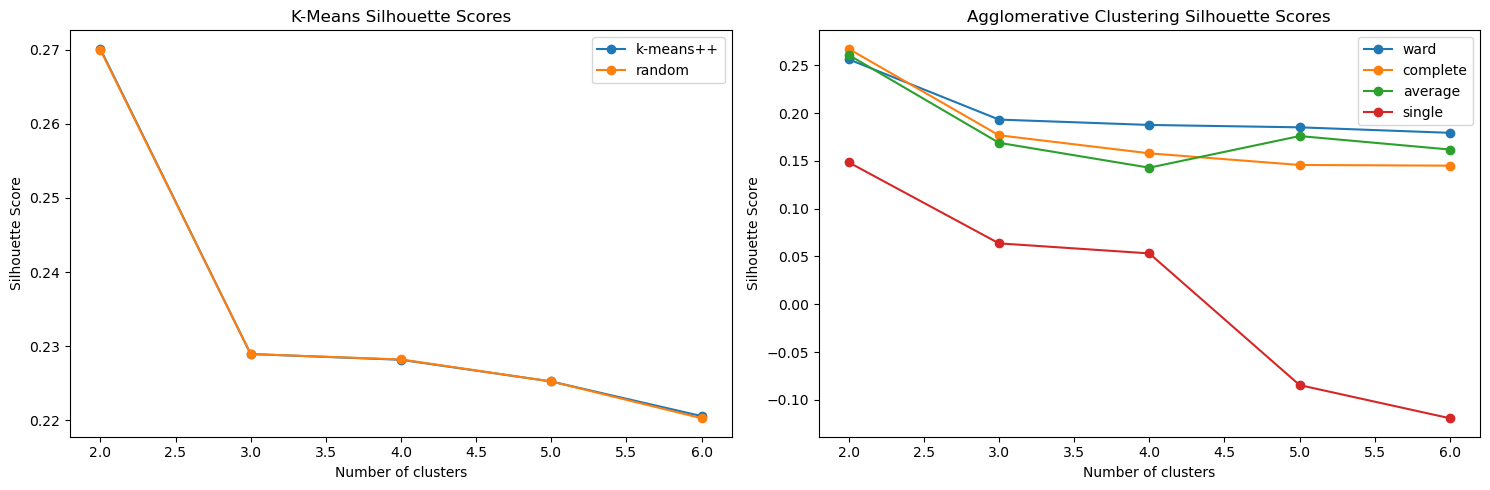

In [17]:

# Hiperparámetros a probar
n_clusters_values = [2, 3, 4, 5, 6]
init_methods = ['k-means++', 'random']
linkage_criteria = ['ward', 'complete', 'average', 'single']

# Listas para guardar los resultados
kmeans_results = []
agglomerative_results = []

# Prueba diferentes configuraciones para K-Means
for n_clusters in n_clusters_values:
    for init in init_methods:
        kmeans = KMeans(n_clusters=n_clusters, init=init, random_state=42)
        kmeans_labels = kmeans.fit_predict(X)
        silhouette = silhouette_score(X, kmeans_labels)
        kmeans_results.append((n_clusters, init, silhouette, kmeans.inertia_))

# Prueba diferentes configuraciones para Clustering Jerárquico
for n_clusters in n_clusters_values:
    for linkage in linkage_criteria:
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        agglomerative_labels = agglomerative.fit_predict(X)
        silhouette = silhouette_score(X, agglomerative_labels)
        agglomerative_results.append((n_clusters, linkage, silhouette))

# Convierte los resultados en DataFrames
kmeans_results = pd.DataFrame(kmeans_results, columns=['n_clusters', 'init', 'silhouette', 'inertia'])
agglomerative_results = pd.DataFrame(agglomerative_results, columns=['n_clusters', 'linkage', 'silhouette'])

# Grafica los resultados
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for init in init_methods:
    plt.plot(kmeans_results[kmeans_results['init'] == init]['n_clusters'],
             kmeans_results[kmeans_results['init'] == init]['silhouette'],
             marker='o', label=init)
plt.title('K-Means Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.legend()

plt.subplot(1, 2, 2)
for linkage in linkage_criteria:
    plt.plot(agglomerative_results[agglomerative_results['linkage'] == linkage]['n_clusters'],
             agglomerative_results[agglomerative_results['linkage'] == linkage]['silhouette'],
             marker='o', label=linkage)
plt.title('Agglomerative Clustering Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.legend()

plt.tight_layout()
plt.show()